In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

In [2]:
training = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('submission.csv')

In [3]:
training.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
training.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
ticket_types = training['Ticket'].apply(lambda x: x.split()[0] if len(x.split()) > 1 else 'None')
ticket_type_counts = ticket_types.value_counts()
print(ticket_type_counts)

Ticket
None          665
PC             60
C.A.           27
STON/O         12
A/5            10
W./C.           9
CA.             8
SOTON/O.Q.      8
SOTON/OQ        7
A/5.            7
CA              6
STON/O2.        6
C               5
F.C.C.          5
S.O.C.          5
SC/PARIS        5
SC/Paris        4
S.O./P.P.       3
PP              3
A/4.            3
A/4             3
SC/AH           3
A./5.           2
SOTON/O2        2
A.5.            2
WE/P            2
S.C./PARIS      2
P/PP            2
F.C.            1
SC              1
S.W./PP         1
A/S             1
Fa              1
SCO/W           1
SW/PP           1
W/C             1
S.C./A.4.       1
S.O.P.          1
A4.             1
W.E.P.          1
SO/C            1
S.P.            1
C.A./SOTON      1
Name: count, dtype: int64


In [7]:
cabin_counts = training['Cabin'].value_counts()
print(cabin_counts)

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 147, dtype: int64


In [8]:
cabin_data = training['Cabin'].str.split()

individual_cabins = []
for i in cabin_data:
    if isinstance(i, list):
        for j in i:
            individual_cabins.append(j[0])
    else:
        if isinstance(i, str):
            individual_cabins.append(i[0])
        else:
            individual_cabins.append('Unknown')


cabin_df = pd.DataFrame({'Cabin': individual_cabins})
cabin_counts_ind = cabin_df['Cabin'].value_counts()
print(cabin_counts_ind)

Cabin
Unknown    687
C           71
B           64
D           34
E           33
A           15
F           13
G            7
T            1
Name: count, dtype: int64


In [9]:
plt.style.use("dark_background")

In [10]:
cabin_df = cabin_df[~cabin_df.index.duplicated(keep='first')]

In [11]:
cabin_df['Survived'] = training['Survived']
cabin_survival_rate = cabin_df.groupby('Cabin')['Survived'].mean()

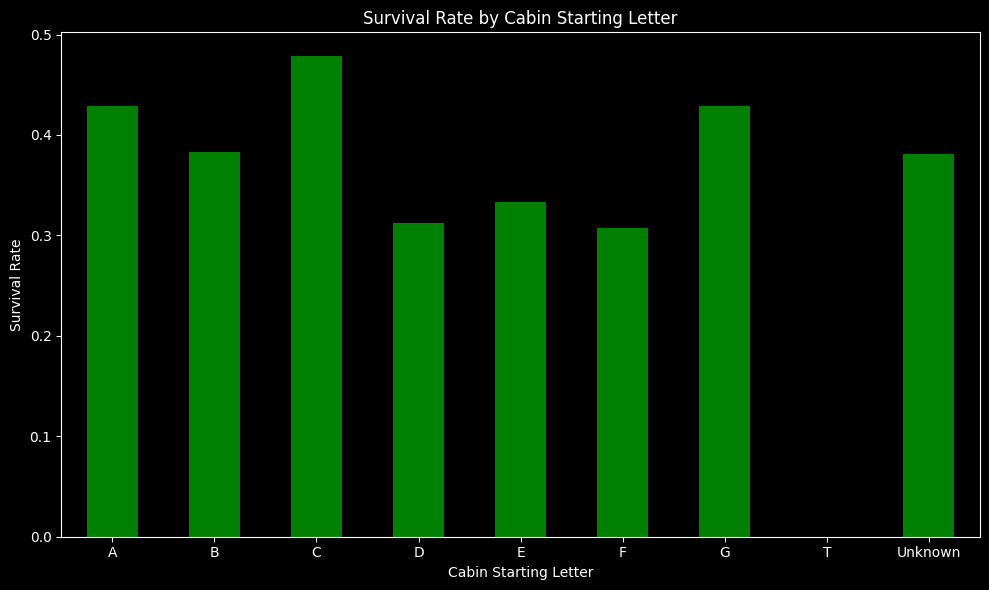

In [12]:
plt.figure(figsize=(10, 6))
cabin_survival_rate.plot(kind='bar', color='green')
plt.title('Survival Rate by Cabin Starting Letter')
plt.xlabel('Cabin Starting Letter')
plt.ylabel('Survival Rate')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

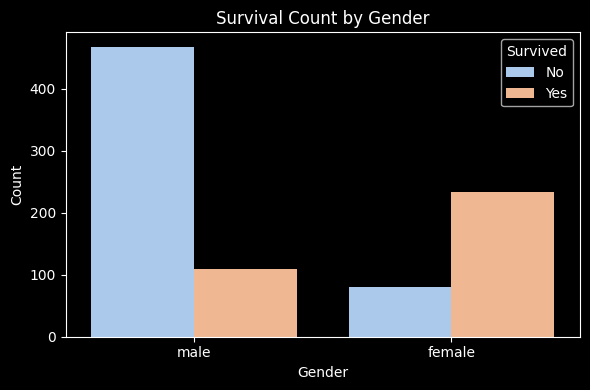

In [13]:
plt.figure(figsize=(6, 4))
sns.countplot(data=training, x="Sex", hue="Survived", palette="pastel")
plt.title("Survival Count by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(title="Survived", labels=["No", "Yes"])
plt.tight_layout()
plt.show()

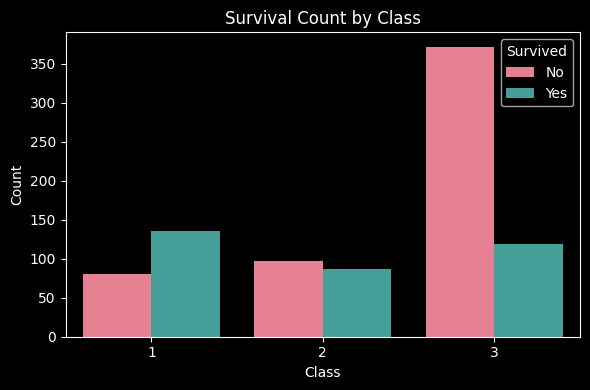

In [14]:
plt.figure(figsize=(6, 4))
sns.countplot(data=training, x="Pclass", hue="Survived", palette="husl")
plt.title("Survival Count by Class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.legend(title="Survived", labels=["No", "Yes"])
plt.tight_layout()
plt.show()

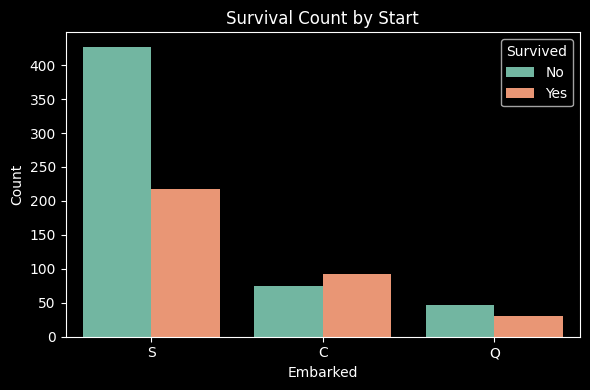

In [15]:
plt.figure(figsize=(6, 4))
sns.countplot(data=training, x="Embarked", hue="Survived", palette="Set2")
plt.title("Survival Count by Start")
plt.xlabel("Embarked")
plt.ylabel("Count")
plt.legend(title="Survived", labels=["No", "Yes"])
plt.tight_layout()
plt.show()

In [16]:
training['FamilySize'] = training['SibSp'] + training['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

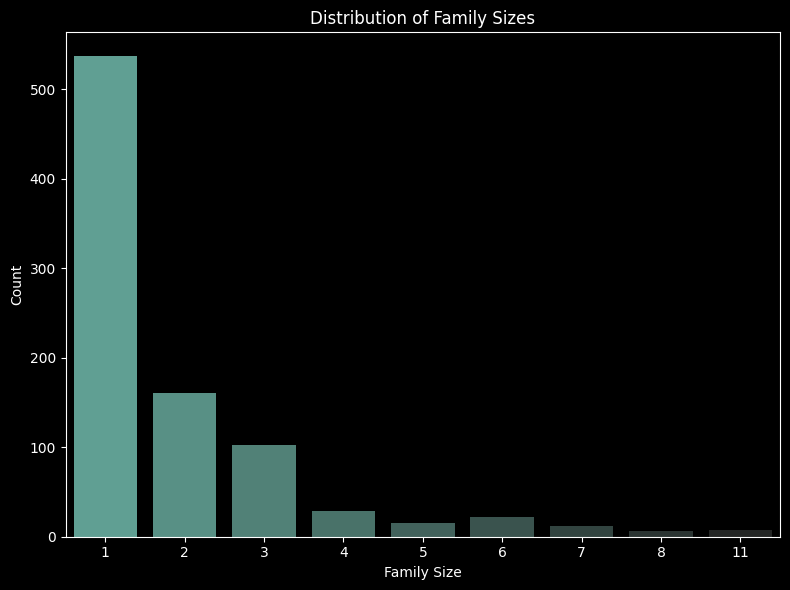

In [17]:
plt.figure(figsize=(8, 6))
sns.countplot(data=training, x="FamilySize", palette="dark:#5A9_r")
plt.title("Distribution of Family Sizes")
plt.xlabel("Family Size")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [18]:
family_survival = training.groupby('FamilySize')['Survived'].mean()

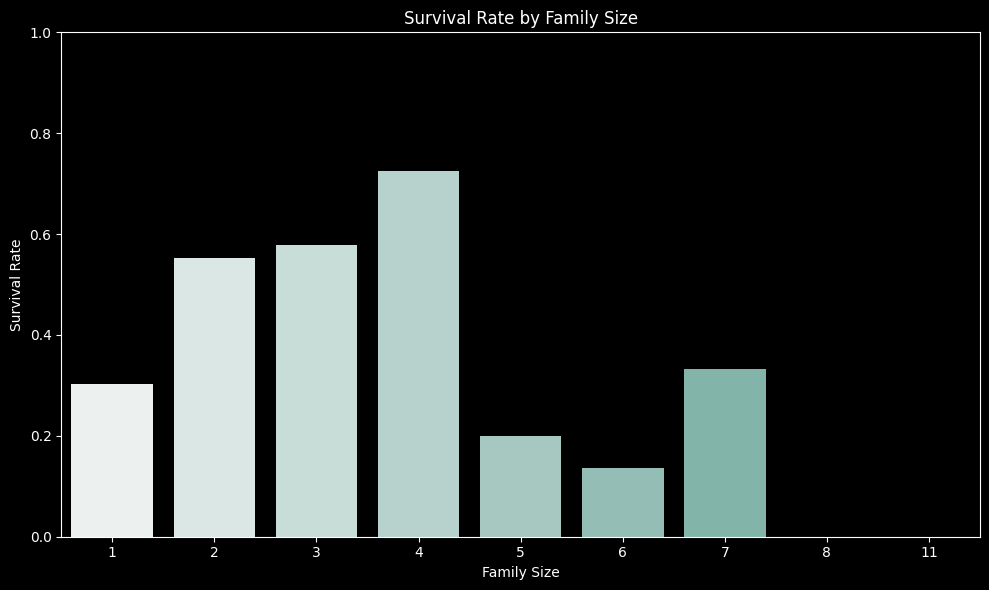

In [19]:
plt.figure(figsize=(10, 6))
sns.barplot(x=family_survival.index, y=family_survival.values, palette="light:#5A9")
plt.title("Survival Rate by Family Size")
plt.xlabel("Family Size")
plt.ylabel("Survival Rate")
plt.ylim(0, 1) 
plt.tight_layout()
plt.show()

(array([ 54.,  46., 177., 169., 118.,  70.,  45.,  24.,   9.,   2.]),
 array([ 0.42 ,  8.378, 16.336, 24.294, 32.252, 40.21 , 48.168, 56.126,
        64.084, 72.042, 80.   ]),
 <BarContainer object of 10 artists>)

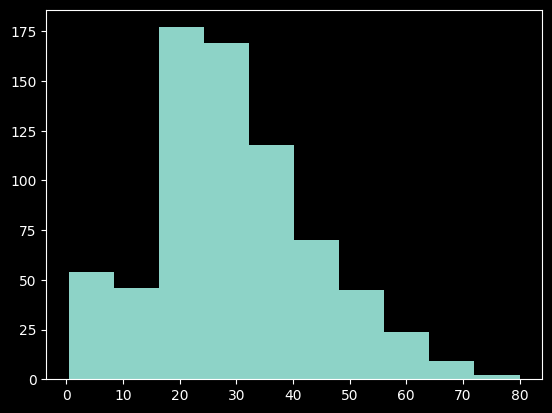

In [20]:
plt.hist(training['Age'])

In [21]:
fare_bins = pd.qcut(training['Fare'], q=8)
fare_survival_rate = training.groupby(fare_bins)['Survived'].mean()

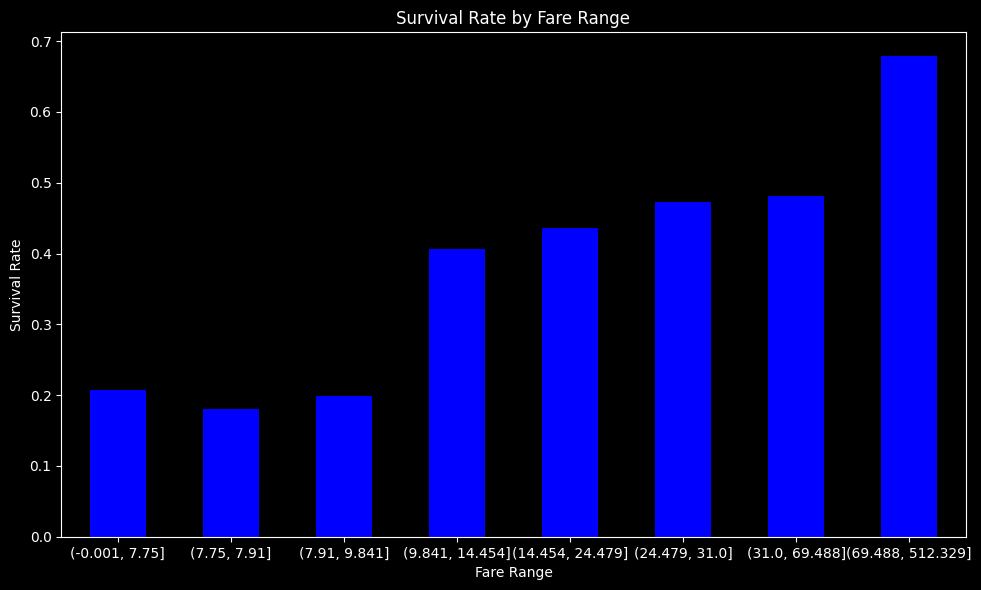

In [22]:
plt.figure(figsize=(10, 6))
fare_survival_rate.plot(kind='bar', color='blue')
plt.title('Survival Rate by Fare Range')
plt.xlabel('Fare Range')
plt.ylabel('Survival Rate')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [23]:
training.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,1
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,1
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,5
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,3
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,2


In [24]:
data_use = training

In [25]:
data_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  FamilySize   891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [26]:
data_use = data_use.drop(['Ticket', 'Name', 'PassengerId'], axis=1)
data_use['Age'] = data_use['Age'].interpolate()
data_use['Embarked'] = data_use['Embarked'].fillna('S')
data_use['Cabin'] = data_use['Cabin'].fillna('U')

test = test.drop(['Ticket', 'Name', 'PassengerId'], axis=1)
test['Age'] = test['Age'].interpolate()
test['Fare'] = test['Fare'].interpolate()
test['Embarked'] = test['Embarked'].fillna('S')
test['Cabin'] = test['Cabin'].fillna('U')

In [27]:
data_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    object 
 3   Age         891 non-null    float64
 4   SibSp       891 non-null    int64  
 5   Parch       891 non-null    int64  
 6   Fare        891 non-null    float64
 7   Cabin       891 non-null    object 
 8   Embarked    891 non-null    object 
 9   FamilySize  891 non-null    int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 69.7+ KB


In [28]:
X = data_use.drop(['Survived'], axis=1)
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

scaler = StandardScaler()
data_use[numerical_cols] = scaler.fit_transform(data_use[numerical_cols])

ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
data_use[categorical_cols] = ordinal_encoder.fit_transform(data_use[categorical_cols].astype(str))

test[numerical_cols] = scaler.transform(test[numerical_cols])
test[categorical_cols] = ordinal_encoder.transform(test[categorical_cols].astype(str))

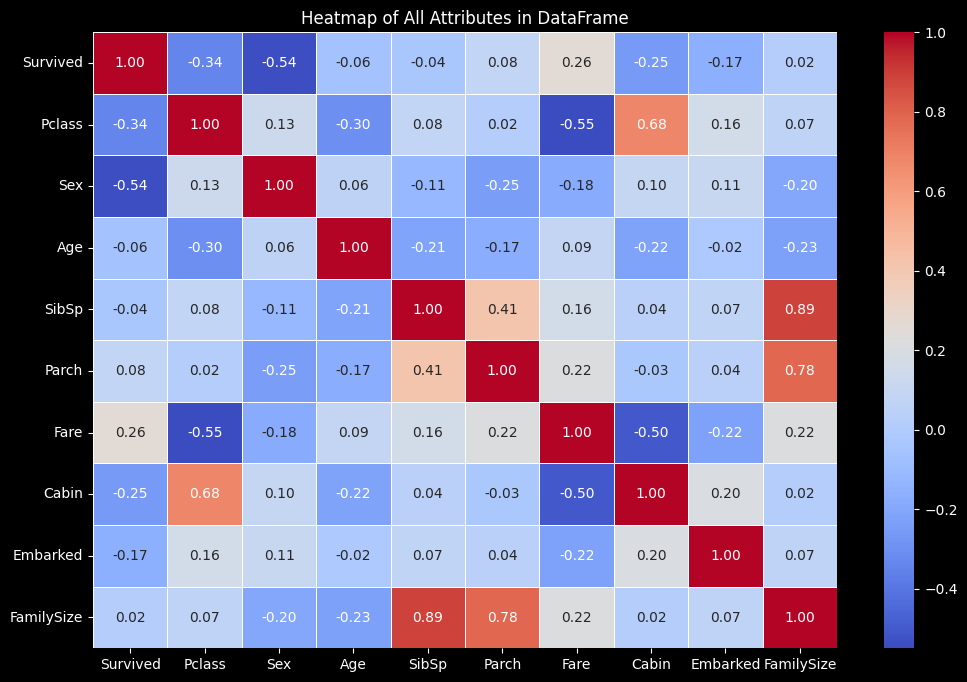

In [29]:
correlation_matrix = data_use.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Heatmap of All Attributes in DataFrame")
plt.show()

In [30]:
data_train, data_test = train_test_split(data_use, test_size=0.25)
X_final = data_use.drop(['Survived'], axis=1)
y_final = data_use['Survived']

In [31]:
X_train = data_train.drop(['Survived'], axis=1)
X_test = data_test.drop(['Survived'], axis=1)
y_train = data_train['Survived']
y_test = data_test['Survived']

In [32]:
model = CatBoostClassifier(learning_rate=0.1, random_seed=42, verbose=0)
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.15],
    'iterations': [100, 200]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=10, verbose=0)

best_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)
print(f"Best CV Accuracy: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Hyperparameters: {'depth': 8, 'iterations': 100, 'learning_rate': 0.1}
Best CV Accuracy: 0.8353


In [33]:
y_pred = best_model.predict(test).astype(int)

In [34]:
submission['Survived'] = y_pred
submission.to_csv('submission.csv', index = False)